Calculate the detsys errors for nue and numu. All detsys errors here are done together, as they are totally different to the nominal samples, and the varience from them calculated. This can then be added back in with the state errors in batch plot construction. 

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [47]:
detvar_run1_fhc = {
    "LYRayleigh": 7.59732E20, #7.60573E20, 
    "LYDown": 7.43109E20, 
    "SCE": 7.39875E20, 
    "Recomb2": 7.59105E20, 
    "WireModX": 7.64918E20, 
    "WireModYZ": 7.532E20, 
    "WireModThetaXZ": 7.64282E20,
    "WireModThetaYZ_withSigmaSplines": 7.64543E20, 
    "CV": 7.59732E20
}

intrinsic_detvar_run1_fhc = {
    "LYRayleigh_intrinsic": 2.67655E22, #2.38081E22, 
    "LYDown_intrinsic": 2.24505E22, 
    "SCE_intrinsic": 2.60685E22, #2.39023E22, 
    "Recomb2_intrinsic":  2.60657E22, #2.38193E22, 
    "WireModX_intrinsic": 2.66184E22, #2.38318E22, 
    "WireModYZ_intrinsic":  2.62256E22, #2.38416E22,
    "WireModThetaXZ_intrinsic": 2.65175E22, #2.31518E22, 
    "WireModThetaYZ_withSigmaSplines_intrinsic": 2.62256E22, #2.31421E22, 
    "CV_intrinsic": 2.68294E22 #2.37261E22   
}


In [48]:
standard_dict = detvar_run1_fhc
intrinsic_dict = intrinsic_detvar_run1_fhc

run = 'run1'
detvar = detvar_run1_fhc

In [49]:
variables = [
    "nu_pdg", "ccnc",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "swtrig_pre", "npion", "nproton", "npi0",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "n_tracks_contained", 
    "shr_tkfit_dedx_Y",  
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trkshrhitdist2",
    "n_showers_contained",
    "shr_score", "tksh_angle", 
    "trk_energy", 
    "tksh_distance", "trk_energy_tot",
    "shr_energy_tot_cali", "shr_energy_cali",
    "nslice", 
    "contained_fraction", 
    "shrmoliereavg", "category",
    "ppfx_cv", "weightSplineTimesTune", "NeutrinoEnergy2", "shr_energy_cali", "nu_e"
]

In [50]:
input_path = "/media/alex/TOSHIBA EXT/detSys/"

In [51]:
detvar.keys()

dict_keys(['LYRayleigh', 'LYDown', 'SCE', 'Recomb2', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ_withSigmaSplines', 'CV'])

In [52]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

In [53]:
beamon_pot = 2e+20

In [54]:
xvar = "reco_e"
bins = np.arange(0, 5.5, 0.5)

xlow = bins[0]
xhigh = bins[-1]

x_label = "Reconstructed Energy [GeV]"

In [55]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

In [56]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

useBDT = True

In [57]:
training_parameters = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]

In [58]:
detvar_dict = {}

In [60]:
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

In [76]:
for variation in detvar.keys(): 
        
    print("Plotting", variation)
    
    standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run+"_overlay_"+variation+".root"
    intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run+"_overlay_"+variation+"_intrinsic.root"
    
    f_standard = uproot.open(standard_input_file)[fold][tree]
    f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]
    
    uproot_v = [f_standard, f_intrinsic]
    
    df_standard = f_standard.pandas.df(variables, flatten=False)
    df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)
    
    print("All good to here.")
    
    INTERCEPT = 0.0
    SLOPE = 0.83
    
    for i, df in enumerate([df_standard, df_intrinsic]):
            
        up = uproot_v[i]
        trk_llr_pid_v = up.array('trk_llr_pid_score_v')
        trk_id = up.array('trk_id')-1 
        trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
        df['trkpid'] = trk_llr_pid_v_sel
        df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
        df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
        
        df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000

        df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
        df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
        df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
        df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
            
        # bool for is signal vs is not signal 
        df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
    
            
        print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))
        
    # APPLY SW TRIGGER
    df_standard = df_standard.query('nslice==1')
    df_intrinsic = df_intrinsic.query('nslice==1')
    
    # POT SCALING
    df_standard['pot_scale'] = beamon_pot/standard_dict.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
    df_standard['pot_scale_dirt'] = (beamon_pot/standard_dict.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
    df_intrinsic['pot_scale'] = beamon_pot/intrinsic_dict.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 
    
    # remove nue CC events 
    print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
    len1 = len(df_standard)

    idx = df_standard.query(nueCC_query).index
    df_standard.drop(idx, inplace=True)
    len2 = len(df_standard) 

    print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above
    
    if useBDT: 
            
        print('Using BDT')
        
        df_bdt_standard = df_standard.copy()
        df_bdt_intrinsic = df_intrinsic.copy()

        # clean datasets 
        for column in training_parameters:
            df_bdt_standard.loc[(df_bdt_standard[column] < -1.0e37) | (df_bdt_standard[column] > 1.0e37), column] = np.nan
            df_bdt_intrinsic.loc[(df_bdt_intrinsic[column] < -1.0e37) | (df_bdt_intrinsic[column] > 1.0e37), column] = np.nan
    
        # apply BDT model
        df_test_standard = xgb.DMatrix(data=df_bdt_standard[training_parameters])
        preds_standard = bdt_model.predict(df_test_standard)
        df_bdt_standard['BDT_score'] = preds_standard
        
        df_test_intrinsic = xgb.DMatrix(data=df_bdt_intrinsic[training_parameters])
        preds_intrinsic = bdt_model.predict(df_test_intrinsic)
        df_bdt_intrinsic['BDT_score'] = preds_intrinsic
        
        df_standard_sel = df_bdt_standard.query(NUE_SEL_QUERY).copy()
        df_intrinsic_sel = df_bdt_intrinsic.query(NUE_SEL_QUERY).copy()
        
    else: 
        df_standard_sel = df_standard.query(NUE_SEL_QUERY).copy()
        df_intrinsic_sel = df_intrinsic.query(NUE_SEL_QUERY).copy()

    standard_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale'])[0]
    plt.close()
    
    print("non-nueCC events = ", sum(standard_counts))
    
    dirt_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale_dirt'])[0]
    plt.close()
    
    print("dirt events = ", sum(dirt_counts))
    
    intrinsic_counts = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]
    plt.close()

    
    print("nue CC events = ", sum(intrinsic_counts))

    
    # store counts in a dictionary 
    detvar_dict[variation] = list(standard_counts)
    detvar_dict[variation+'_intrinsic'] = list(intrinsic_counts)
    detvar_dict[variation+'_dirt'] = list(dirt_counts)

Plotting LYRayleigh
All good to here.
is_signal check: True
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3045
# of nueCC in AV removed = 3045
Using BDT


/tmp/ipykernel_8070/477303600.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intrinsic['pot_scale'] = beamon_pot/intrinsic_dict.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic')


non-nueCC events =  8.1559298664025
dirt events =  6.116947399801875
nue CC events =  62.434459775805664
Plotting LYDown
All good to here.
is_signal check: True
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3008
# of nueCC in AV removed = 3008
Using BDT
non-nueCC events =  8.100999658545886
dirt events =  6.075749743909414
nue CC events =  64.87601084083146
Plotting SCE
All good to here.
is_signal check: True
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3007
# of nueCC in AV removed = 3007
Using BDT
non-nueCC events =  8.506659707870941
dirt events =  6.379994780903203
nue CC events =  62.432519250830026
Plotting Recomb2
All good to here.
is_signal check: True
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3127
# of nueCC in AV removed = 3127
Using BDT
non-nueCC events =  6.620181536435957
dirt events =  4.965136152326967
nue CC events =  64.79669858919557
Plotting WireModX
All good to here.
is_signa

In [77]:
## CV background event rate 
x1 = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale'])[0]

plt.close()

x3 = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale_dirt'])[0]

plt.close()

x2 = plt.hist(df_intrinsic_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
            weights=df_intrinsic_sel.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel.query('is_signal==False')['pot_scale'])[0]

plt.close()

In [78]:
detvar_dict['cv_total_bkgd'] = x1+x2+x3

In [79]:
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]
bin_centers = []
for a in range(len(bins)-1): 
    bin_centers.append(round(bins[a] + (bins[a+1]-bins[a])/2, 3))

In [80]:
#background should correspond to the dirt?

detvar_dict['cv_total_bkgd']

array([7.09148894e+00, 9.17737186e+00, 2.84909745e+00, 1.66987659e+00,
       2.79404672e-01, 1.00283543e-01, 5.56814590e-01, 4.01051332e-02,
       1.51463753e-02, 8.57110233e-03])

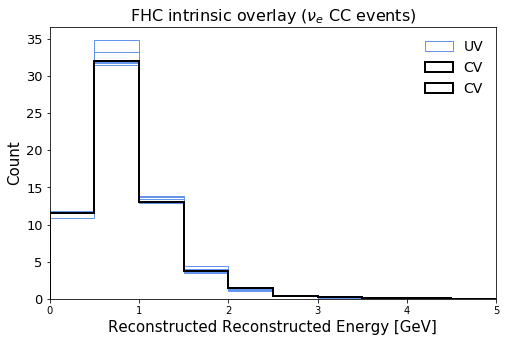

In [81]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV_intrinsic': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV_intrinsic'], color='black', label='CV', linewidth=2)

current = (plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV_intrinsic'], color='black', label='CV', linewidth=2)[0])

plt.title('FHC intrinsic overlay ($\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Count' , fontsize=15) # 2.68294E22
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

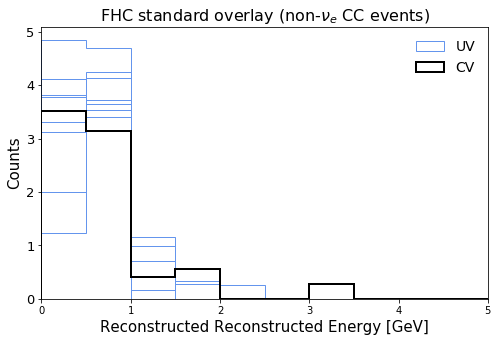

In [82]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV'], color='black', label='CV', linewidth=2)


plt.title('FHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_standard.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

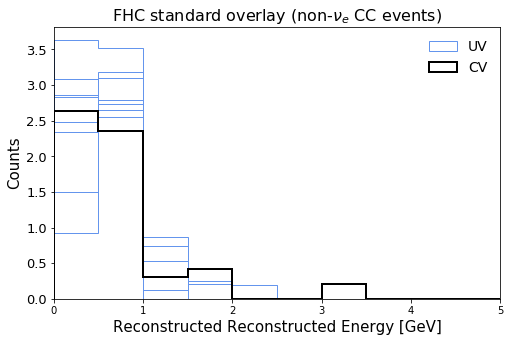

In [101]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict['CV_dirt'], color='black', label='CV', linewidth=2)


plt.title('FHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_standard.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

In [84]:
#Dedicated CV here must be with state uncertainties of nominal CV from other files

#the nue wanted list from batch processing
standard = [10.449224075510086, 31.07824842226588, 11.142672530720944, 2.7208182211142926, 1.0626423368548643, 0.3260199520259164, 0.13695140632728453, 0.0804829838961254, 0.020303320127453617, 0.02014767711723664]
fullnue = [1.13335671e+01, 3.47345335e+01, 1.30243869e+01, 3.51431880e+00,
 1.41404639e+00, 4.08662548e-01, 2.09075728e-01 ,1.19576309e-01,
 2.03033201e-02, 2.89523075e-02]

print(current - standard)
print("")
print(current - fullnue)

[ 1.13263788e+00  9.60562650e-01  1.90303466e+00  1.03433562e+00
  3.57732777e-01  2.27041572e-02  6.23071606e-02  2.39844668e-02
  3.07573229e-02 -1.66896469e-03]

[ 0.24829486 -2.69572243  0.02132029  0.24083504  0.00632872 -0.05993844
 -0.00981716 -0.01510886  0.03075732 -0.0104736 ]


In [85]:
detvar_dict['CV_intrinsic']

[11.58186196012342,
 32.03881107208455,
 13.045707191028598,
 3.755153836166542,
 1.4203751141928862,
 0.3487241092027986,
 0.19925856697441446,
 0.10446745071442365,
 0.05106064305851277,
 0.018478712422449917]

In [36]:
def calcCov(var, bins, ncv_nu, ncv_total, uni_counts, plot=False, save=False, axis_label=None, pot=None, isrun3=False, xticks=None, xhigh=None): 
    
    # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
    # ncv total is the total event rate -- (MC + EXT or estimated signal)
    # when background subtracting these two are the same  
    
    # compute the cov matrix 
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    N = len(uni_counts)
    print('number of universes = ', N)

    #####################################################
    
    for k in range(N): 
        
        uni = uni_counts[k]

        for i in range(len(bins)-1): 

            cvi = ncv_nu[i]
            uvi = uni[i]


            for j in range(len(bins)-1): 
                
                cvj = ncv_nu[j]
                uvj = uni[j]
        
                c = ((uvi - cvi)*(uvj - cvj)) / N

                cov[i][j] += c
                
                
                if ncv_total[i]*ncv_total[j] != 0: 
                    frac_cov[i][j] += c/(ncv_total[i]*ncv_total[j])
                    #frac_cov[i][j] = c/(ncv_total[i]*ncv_total[j])
            
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, cov, cmap='OrRd', edgecolors='k')
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)

        plt.title('Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_cov.pdf", transparent=True, bbox_inches='tight') 
            print('saving to: '+save)
        plt.show()
        
        ##################################
        # fractional covariance 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, frac_cov, cmap='OrRd', edgecolors='k')#, vmin=0, vmax=.03)
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        plt.title('Fractional Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_frac_cov.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################    
    # compute the corr matrix 

    for i in range(len(cov)): 
        for j in range(len(cov[i])): 
            
            #print(i, j, cov[i][j], cov[i][i], cov[j][j])

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
            #print(cor[i][j])
    
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))

        plt.pcolor(bins, bins, cor, cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
    

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])
            
        plt.title('Correlation Matrix', fontsize=16)
        if save: 
            plt.savefig(save+var+"_cor.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################
    
    # sys_err = [np.sqrt(x) for x in np.diagonal(cov)]
    # percent error = [y/z for y,z in zip(sys_err, ncv)] # w.r.t. to whatever event rate is being used (total or background subtracted)
        
    dictionary = {
        'cov' : cov, 
        'frac_cov' : frac_cov, 
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    }
           
    return dictionary

In [87]:
detvar_dict['CV_dirt']

[2.6361025118209844,
 2.359481834169267,
 0.3054882793899809,
 0.41387773390862126,
 0.0,
 0.0,
 0.20561142888594652,
 0.0,
 0.0,
 0.0]

In [102]:
# need to CV background subtract before computing the covariance

detsys_cov_fhc = {}

for variation in detvar_run1_fhc.keys(): 
    
    print(variation)
    
    if variation=='CV': 
        continue
        
        
    # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
    # ncv total is the total event rate -- (MC + EXT or estimated signal)
    # when background subtracting these two are the same
    # so can just add in dirt with the others
    #detsys_cov_fhc[variation] = calcCov(xvar, bins, 
    #                                    [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
    #                                    [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
    #                                    [ [(a+b+d)-c for a,b,c,d in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'], detvar_dict[variation+"_dirt"])] ] )
    
    detsys_cov_fhc[variation] = calcCov(xvar, bins, 
                                        [(a+b)-c for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
                                        [(a+b)-c for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
                                        [ [(a+b)-c for a,b,c in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'])] ] )
    

LYRayleigh
number of universes =  1
LYDown
number of universes =  1
SCE
number of universes =  1
Recomb2
number of universes =  1
WireModX
number of universes =  1
WireModYZ
number of universes =  1
WireModThetaXZ
number of universes =  1
WireModThetaYZ_withSigmaSplines
number of universes =  1
CV


In [103]:
cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
            
        cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
        frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
        
# compute the corr matrix 
for i in range(len(cov)): 
    for j in range(len(cov[i])): 

        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
            cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
    'cor' : cor
} 

<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_8070/2880698531.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
/tmp/ipykernel_8070/2880698531.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])


In [104]:
detsys_dict['fractional_uncertainty']

array([0.44377069, 0.15158629, 0.22605396, 0.38466727, 0.38410467,
       0.88699851, 8.06537968, 1.03924842, 1.2796353 , 7.5923015 ])

In [95]:
np.savetxt("nue_nue_detsys_fracerr_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub.csv", 
           detsys_dict['fractional_uncertainty'],
           delimiter =", ", 
           fmt ='% s')

In [105]:
detsys_dict['cov']

[[12.619991075132248,
  -3.0276847940816443,
  -0.7113670886816114,
  -0.5737578550673146,
  -0.42852397531371195,
  -0.4422494725563152,
  0.6344004836947518,
  -0.09166997956346634,
  0.028055542725033154,
  -0.13751711857851123],
 [-3.0276847940816443,
  15.542262420588214,
  4.629746541979381,
  -2.0214989125989007,
  -0.3521200825087942,
  0.6780098872150361,
  -1.2265157384770848,
  -0.014590698644129027,
  -0.13879098158227057,
  0.1507154262012152],
 [-0.7113670886816114,
  4.629746541979381,
  5.745895634776835,
  -1.4741169223390536,
  -0.5105069744885693,
  0.3585469879596386,
  -1.3129229092876713,
  -0.03743360956033974,
  -0.047417847205112634,
  0.11414985097871573],
 [-0.5737578550673146,
  -2.0214989125989007,
  -1.4741169223390536,
  1.0290307276363322,
  0.33049392535725064,
  -0.10107825669221121,
  0.46673738330206127,
  0.005256144740187776,
  0.028783984289330357,
  -0.046360578751271864],
 [-0.42852397531371195,
  -0.3521200825087942,
  -0.5105069744885693,
  0.

In [106]:
#detsys_err = np.sqrt( np.diag((detsys_dict['cov'])))
#varience
detsys_err = ( np.diag((detsys_dict['cov'])))
print(detsys_err)

[1.26199911e+01 1.55422624e+01 5.74589563e+00 1.02903073e+00
 1.92064884e-01 4.85613561e-02 4.52542464e-01 4.47406298e-03
 2.11206099e-03 5.65828354e-03]


In [107]:
np.savetxt("nue_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_nodirt.csv", 
           detsys_err,
           delimiter =", ", 
           fmt ='% s')

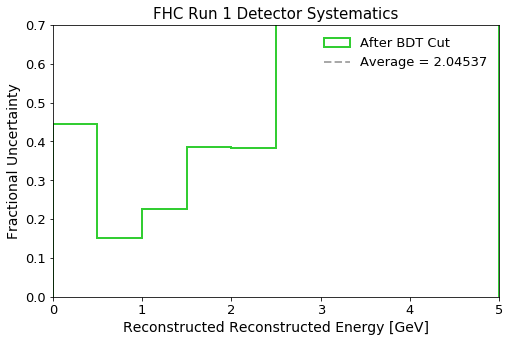

In [109]:
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

plt.figure(figsize=(8, 5))

#cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
#cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

plt.hist(bin_centers, bins, weights=detsys_dict['fractional_uncertainty'], histtype='step', 
         label='After BDT Cut', color='limegreen', linewidth=2)

plt.hlines(np.average(detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(detsys_dict['fractional_uncertainty']), 5)))

plt.xlim(xlow, xhigh)
plt.ylim(0, 0.7)

plt.legend(fontsize=13,  frameon=False)

plt.xlabel("Reconstructed "+x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 Detector Systematics", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

# Intrinsic

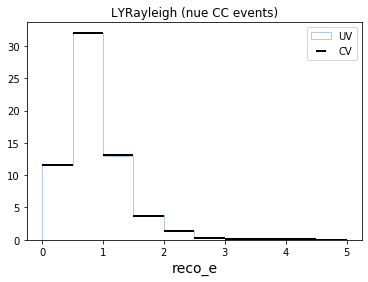

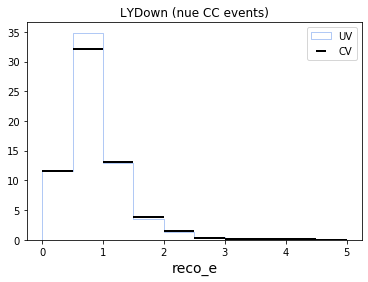

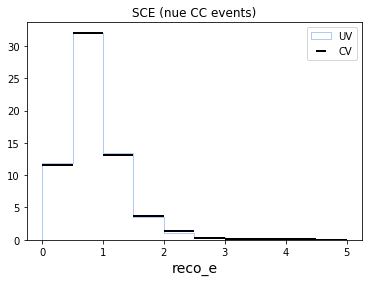

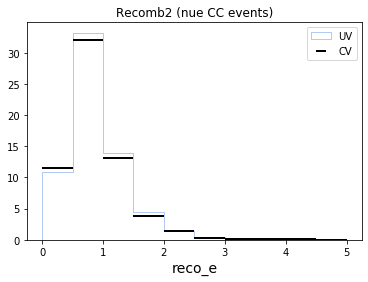

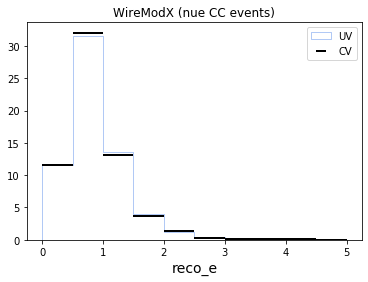

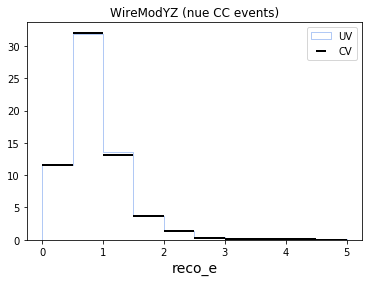

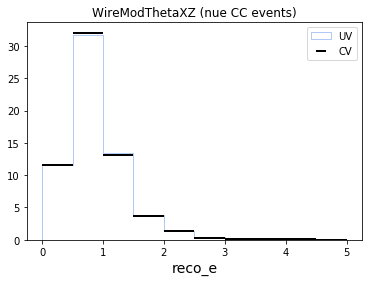

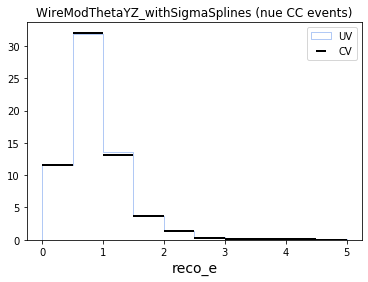

In [110]:
for variation in detvar: 
    
    if variation=='CV': 
        continue
    
    plt.hist(bin_centers, bins, histtype='step', 
                        range=[bins[0], bins[-1]], weights=detvar_dict[variation+'_intrinsic'], 
                        color='cornflowerblue', linewidth=0.5, label='UV')
    
    plt.errorbar(bin_centers, detvar_dict['CV_intrinsic'], xerr=x_err, fmt='none', color='black', linewidth=2, label='CV')
    plt.xlabel(xvar, fontsize=14)
    #plt.ylabel('$\\nu$ / '+str(beamon_pot)+' POT', fontsize=14)
    plt.title(variation+' (nue CC events)')
    plt.legend()
    plt.show()

In [111]:
detsys_cov_nueCC = {}


for variation in detvar.keys(): 
    
    if variation=='CV': 
        continue
   
    detsys_cov_nueCC[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict['CV_intrinsic'], 
                                              detvar_dict['CV_intrinsic'], 
                                              [detvar_dict[variation+'_intrinsic']])
  

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [112]:
# TOTAL cov, corr, fractional uncertainty -- nue CC 


cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
            frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])

for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
nueCC_detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

nueCC_detsys_dict['fractional_uncertainty']

<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_8070/1594932613.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_8070/1594932613.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])


array([0.06078816, 0.09721877, 0.11055273, 0.21268801, 0.30728925,
       0.63192193, 0.2462487 , 0.64028017, 0.90005065, 4.07071452])

In [113]:
nueCC_detsys_err = ( np.diag((nueCC_detsys_dict['cov'])))
print(nueCC_detsys_err)

[4.95672485e-01 9.70181655e+00 2.08005187e+00 6.37883662e-01
 1.90502575e-01 4.85613561e-02 2.40758657e-03 4.47406298e-03
 2.11206099e-03 5.65828354e-03]
